In [5]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from math import log
from tqdm import tqdm
from sklearn import metrics

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Task 3 and 4_Loan_Data.csv to Task 3 and 4_Loan_Data.csv


In [3]:
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

In [6]:
df['payment_to_income'] = df['loan_amt_outstanding'] / df['income']
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']

# Features to use in the model
features = ['credit_lines_outstanding', 'debt_to_income', 'payment_to_income', 'years_employed', 'fico_score']
X = df[features]
y = df['default']

# Standardize features to help model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up and fit logistic regression model
model = LogisticRegression(random_state=0, solver='liblinear', max_iter=10000)
model.fit(X_scaled, y)

# Print model coefficients and intercept
print("Model Coefficients:")
for feature, coef in zip(features, model.coef_[0]):
    print(f"  {feature}: {coef:.4f}")
print(f"Intercept: {model.intercept_[0]:.4f}")

# Predict probabilities and labels
probs = model.predict_proba(X_scaled)[:, 1]
preds = model.predict(X_scaled)

# Calculate error rate and AUC
error = np.mean(np.abs(y - preds))
fpr, tpr, _ = metrics.roc_curve(y, probs)
auc = metrics.auc(fpr, tpr)

print(f"\nError rate: {error:.4f}")
print(f"AUC: {auc:.4f}")


Model Coefficients:
  credit_lines_outstanding: 6.4449
  debt_to_income: 3.2183
  payment_to_income: 0.1350
  years_employed: -2.1860
  fico_score: -0.9450
Intercept: -10.4755

Error rate: 0.0012
AUC: 1.0000


In [14]:
import pandas as pd
import numpy as np
from math import log


# Pull out target and FICO score
defaults = df['default'].tolist()
fico = df['fico_score'].astype(int).tolist()

# We'll bin scores from 300 to 850 (inclusive)
min_score = 300
max_score = 850
bins = max_score - min_score + 1

# Set up arrays to track cumulative defaults and totals
cum_defaults = [0] * bins
cum_totals = [0] * bins

# Count defaults and totals per FICO score
for i in range(len(defaults)):
    idx = fico[i] - min_score
    cum_defaults[idx] += defaults[i]
    cum_totals[idx] += 1

# Make cumulative sums for easier segment calculations
for i in range(1, bins):
    cum_defaults[i] += cum_defaults[i - 1]
    cum_totals[i] += cum_totals[i - 1]

# Likelihood function with simple error checks
def log_likelihood(n, k):
    if n == 0 or k == 0 or k == n:
        return 0
    p = k / n
    return k * log(p) + (n - k) * log(1 - p)

# Try to split into 10 buckets
r = 10
dp = [[[-1e18, 0] for _ in range(bins)] for _ in range(r + 1)]
dp[0][0][0] = 0  # Base case
min_bin_size = 10

# Fill DP table with min bin size constraint
for i in range(1, r + 1):
    for j in range(1, bins):
        # k should be at most j - min_bin_size to ensure segment size >= min_bin_size
        for k in range(j - min_bin_size + 1):
            total = cum_totals[j] - cum_totals[k]
            default = cum_defaults[j] - cum_defaults[k]
            if total < min_bin_size:
                continue
            ll = log_likelihood(total, default)
            if dp[i][j][0] < dp[i - 1][k][0] + ll:
                dp[i][j][0] = dp[i - 1][k][0] + ll
                dp[i][j][1] = k


# Get max log-likelihood
max_ll = dp[r][bins - 1][0]
print(f"Max Log-Likelihood: {max_ll:.4f}")

# Backtrack to find cutoff points
cutoffs = []
idx = bins - 1
level = r
while level > 0:
    idx = dp[level][idx][1]
    cutoffs.append(idx + min_score)
    level -= 1

# Sort and show cutoffs
cutoffs = sorted(list(set(cutoffs)))
print("FICO score cutoffs:", cutoffs)


Max Log-Likelihood: -4219.2770
FICO score cutoffs: [300, 502, 520, 552, 580, 610, 639, 649, 696, 732]


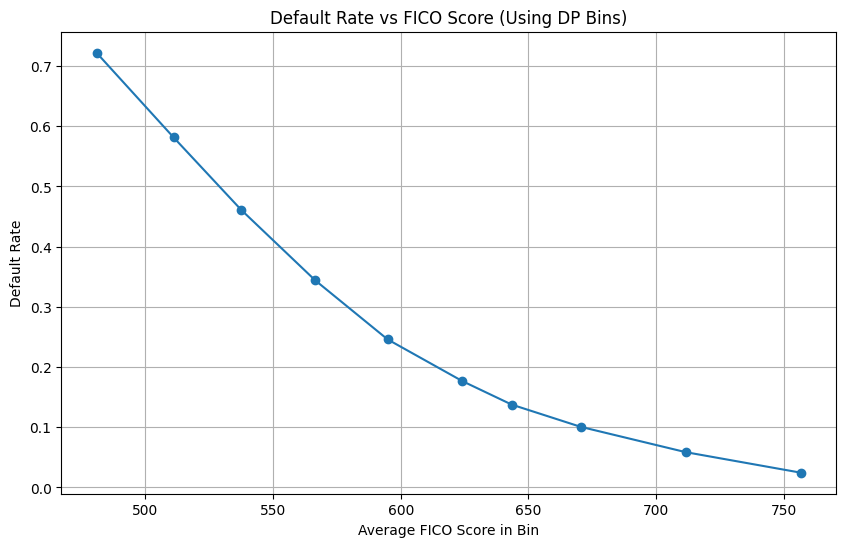

In [19]:
import matplotlib.pyplot as plt

# Add min and max to the cutoffs for full coverage
bin_edges = [300] + cutoffs + [850]

fico_avg = []
default_rate = []

for start, end in zip(bin_edges[:-1], bin_edges[1:]):
    bin_df = df[(df['fico_score'] >= start) & (df['fico_score'] < end)]
    if len(bin_df) == 0:
        continue
    fico_avg.append(bin_df['fico_score'].mean())
    default_rate.append(bin_df['default'].mean())

plt.figure(figsize=(10, 6))
plt.plot(fico_avg, default_rate, marker='o', linestyle='-')
plt.title('Default Rate vs FICO Score')
plt.xlabel('Average FICO Score in Bin')
plt.ylabel('Default Rate')
plt.grid(True)
plt.show()
